In [ ]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)

/local/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SpikeInterface version: 0.103.2


In [2]:
def extract_datetime(path):
    """
    Extract datetime from a file path containing datetime string in format YYMMDD_HHMMSS.
    
    Parameters
    ----------
    path : str
        Path to extract datetime from.
    
    Returns
    -------
    datetime
        Extracted datetime object. Returns datetime.min if pattern not found.
    """
    m = re.search(r'(\d{6}_\d{6})', path)
    if m:
        return datetime.strptime(m.group(1), "%y%m%d_%H%M%S")
    return datetime.min

In [3]:
# Set base path and load recording data
# basepath = "/local/workdir/ys2375/PreprocessPipeline/data/hp18_day86"
basepath = "/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03"
dataPath = glob.glob(basepath + '/*/amplifier.dat')
dataPath = sorted(dataPath, key=extract_datetime)
display(dataPath)

# Load channel map
chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]

['/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_presleep_251120_094656/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_nostim_251120_113356/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_1_251120_113814/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_2_251120_114305/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_circular_maze_wstim_3_251120_114753/amplifier.dat',
 '/local/workdir/ys2375/PreprocessPipeline/data/whiskey_day03/whiskey_postsleep_251120_115758/amplifier.dat']

[]


(<matplotlib.collections.PolyCollection at 0x7f3f434e0510>, None)

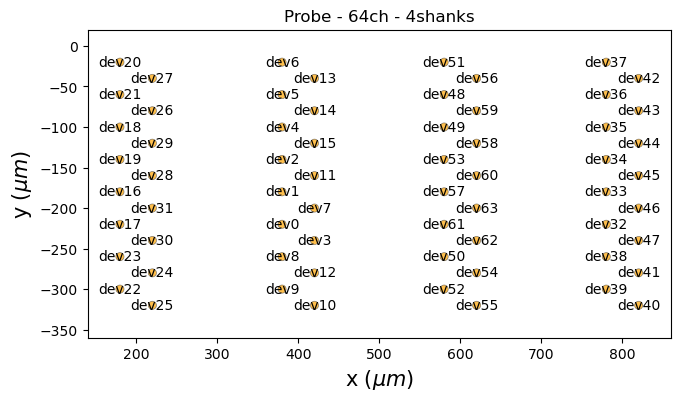

In [4]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
coords = np.column_stack((x, y))
shank_ids = chanMapmat['kcoords'].flatten()
device_ch_inds = chanMapmat['chanMap'].flatten() - 1
bad_ch_ids = np.where(chanMapmat['connected'][:,0]==0)[0]
print(bad_ch_ids)

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(
    positions=coords,
    shapes='circle',
    shape_params={'radius': 5},
    shank_ids=shank_ids
)
probe.set_device_channel_indices(device_ch_inds)

fig, ax = plt.subplots(figsize=(8,4)) 
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)